### Import des données

In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import itertools as it
import statsmodels.api as sm

In [392]:
df_corkstation = pd.read_csv("Corkstation_15072019_01022011.csv")

In [393]:
df_vst = pd.read_csv("df_vst_group6.csv")

### Prétraitement


Interpolating incomplete data from df_corkstation

In [394]:
# Changing index to date column
df_corkstation['date'] = pd.to_datetime(df_corkstation['date'])
df_corkstation.set_index('date', inplace=True)

# Interpolating over missing data
df_corkstation = df_corkstation.replace({' ': '-1'}, regex=True)
df_corkstation['wetb'] = pd.to_numeric(df_corkstation['wetb'])
df_corkstation['vis'] = pd.to_numeric(df_corkstation['vis'])
df_corkstation = df_corkstation.replace({-1: np.nan}, regex=True)
df_corkstation = df_corkstation.interpolate()

Resample and interpolating

In [395]:
# Resample for each 30 min and interpolating
df_corkstation_resampled = df_corkstation.resample('30T').interpolate(method='linear')

Adding week-end, season info

In [396]:
# Lists to be used
weekend_list = []
season_list = []
work_time_list = []
year_list = []
month_list = []
day_list = []
hour_list = []
minute_list=[]
weekofyear_list = []
hours_array = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]         # 1 ... 24
 
# Get season function
def get_season(date):
    year = date.year
    seasons = {
        'spring': (pd.Timestamp(year=year, month=3, day=21), pd.Timestamp(year=year, month=6, day=20)),
        'summer': (pd.Timestamp(year=year, month=6, day=20), pd.Timestamp(year=year, month=9, day=20)),
        'fall': (pd.Timestamp(year=year, month=9, day=21), pd.Timestamp(year=year, month=12, day=20)),
        'winter': (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year + 1, month=3, day=19))
    }
    
    if seasons['spring'][0] <= date <= seasons['spring'][1]:
        return 1
    elif seasons['summer'][0] <= date <= seasons['summer'][1]:
        return 2
    elif seasons['fall'][0] <= date <= seasons['fall'][1]:
        return 3
    else:
        return 4
    
# Adding info to lists
for date in df_corkstation_resampled.index.tolist():
    if date.weekday() == 5 or date.weekday() == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

    season_list.append(get_season(date))
    year_list.append(date.year)
    month_list.append(date.month)
    day_list.append(date.day)
    hour_list.append(date.hour)
    minute_list.append(date.minute)
    weekofyear_list.append(date.weekofyear)

    if date.hour >= 9 and date.hour <= 18:
        work_time_list.append(1)
    else:
        work_time_list.append(0)

    #for hour in range(1, 25):
    #    if hour == date.hour:
    #        hours_array[hour-1].append(1)
    #    else:
    #        hours_array[hour-1].append(0)

# Creating dataframes with info
weekend_df = pd.DataFrame({'weekend': weekend_list})
season_df = pd.DataFrame({'season': season_list})
work_time_df = pd.DataFrame({'work_time': work_time_list})
year_df = pd.DataFrame({'year': year_list})
month_df = pd.DataFrame({'month': month_list})
day_df = pd.DataFrame({'day': day_list})
hour_df = pd.DataFrame({'hour': hour_list})
minute_df = pd.DataFrame({'minute': minute_list})
weekofyear_df = pd.DataFrame({'weekofyear': weekofyear_list})

#hours_dfs = []
#for hour in range(1, 25):
#    hours_dfs.append(pd.DataFrame({f'hour{hour}': hours_array[hour-1]}))
#hours_df = pd.concat(hours_dfs, axis=1)

# Concating created info to the dataframe corkstation
time_info = pd.concat([weekend_df, season_df, work_time_df, year_df, month_df, day_df, hour_df, minute_df, weekofyear_df], axis=1)
time_info.set_index(df_corkstation_resampled.index, inplace=True)
df_corkstation_resampled = pd.concat([df_corkstation_resampled, time_info], axis=1)

Deleting last data from dataframes to match the consumption data

In [397]:
date_to_be_cropped = datetime.datetime(2010, 12, 14, 23, 0)
df_corkstation_cropped = df_corkstation_resampled[df_corkstation_resampled.index <= date_to_be_cropped]

df_vst['time'] = pd.to_datetime(df_vst['time'])
df_vst.set_index('time', inplace=True)
df_vst_cropped = df_vst[df_vst.index<=date_to_be_cropped]

Merging two dataframes

In [398]:
df_corkstation_cropped = df_corkstation_cropped.drop(columns=['temp'])
df_to_train_and_test = pd.concat([df_corkstation_cropped, df_vst_cropped], axis=1)

Analisying data

Getting best variables based on AIC criterion

In [399]:
def best_aic(df):
    # Dependent and independent variables 
    y = df['mean']
    # Removing variables with weak corrolation with mean
    X = df.drop(columns=['mean', 'ind.3', 'ind.4','rain','ww','w','weekend','month','minute','clamt','year','day'])
    X = sm.add_constant(X)
    
    # List to armazain the selected variables
    selected_features = []
    remaining_features = list(X.columns)
    remaining_features.remove('const')
    
    current_score, best_new_score = float('inf'), float('inf')
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            candidates = selected_features + [candidate]
            X_subset = X[candidates]
            model = sm.OLS(y, X_subset).fit()
            score = model.aic
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if current_score > best_new_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
        else:
            break
    
    return selected_features

# Getting the best variables
#best_features = best_aic(df_to_train_and_test)
#print(f'Best Features: {best_features}')

Decision Tree

In [400]:
variables = ['hour', 'season', 'work_time', 'temp', 'rhum', 'msl', 'ind', 'weekofyear', 'sun', 'ind.1', 'clht', 'vappr', 'dewpt', 'wddir']

x_train, x_test, y_train, y_test = train_test_split(df_to_train_and_test[variables], df_to_train_and_test['mean'], test_size=0.2, random_state=42)

x_train_hard, x_test_hard, y_train_hard, y_test_hard = train_test_split(df_to_train_and_test[variables], df_to_train_and_test['mean'], test_size=0.2, random_state=42, shuffle=False)

regr = RandomForestRegressor(n_jobs=-1)

Search of hyperparameters with RandomizedSearchCV for data and training

In [401]:
'''
parameters_ranodmizedSearch = {  
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [None, 10, 50, 100],
    'n_estimators': [10, 50, 100],
    'max_features': [None, 'sqrt']
}

clf_randomSearch = RandomizedSearchCV(regr, parameters_ranodmizedSearch, scoring='neg_mean_absolute_percentage_error', random_state=0, n_jobs=-1)
clf_randomSearch.fit(x_train, y_train)
'''

"\nparameters_ranodmizedSearch = {  \n    'criterion': ['squared_error', 'absolute_error', 'poisson'],\n    'max_depth': [None, 10, 50, 100],\n    'n_estimators': [10, 50, 100],\n    'max_features': [None, 'sqrt']\n}\n\nclf_randomSearch = RandomizedSearchCV(regr, parameters_ranodmizedSearch, scoring='neg_mean_absolute_percentage_error', random_state=0, n_jobs=-1)\nclf_randomSearch.fit(x_train, y_train)\n"

In [402]:
'''
results_randomSearch = pd.DataFrame(clf_randomSearch.cv_results_)
results_randomSearch = results_randomSearch.sort_values(by=['rank_test_score'])
results_randomSearch = results_randomSearch[['mean_fit_time', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_criterion', 'mean_test_score','rank_test_score']]

results_randomSearch.head()
'''

"\nresults_randomSearch = pd.DataFrame(clf_randomSearch.cv_results_)\nresults_randomSearch = results_randomSearch.sort_values(by=['rank_test_score'])\nresults_randomSearch = results_randomSearch[['mean_fit_time', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_criterion', 'mean_test_score','rank_test_score']]\n\nresults_randomSearch.head()\n"

In [403]:
regr_optimal = RandomForestRegressor(criterion='poisson', max_depth=None, max_features=None, n_estimators=10, random_state = 0)
regr_optimal.fit(x_train, y_train)

RandomForestRegressor(criterion='poisson', max_features=None, n_estimators=10,
                      random_state=0)

Search of hyperparameters with RandomizedSearchCV for hard data and training

In [404]:
'''
tscv = TimeSeriesSplit(n_splits=5)
clf_randomSearch = RandomizedSearchCV(regr, parameters_ranodmizedSearch, scoring='neg_mean_absolute_percentage_error', random_state=0, n_jobs=-1, cv = tscv)
clf_randomSearch.fit(x_train_hard, y_train_hard)
'''

"\ntscv = TimeSeriesSplit(n_splits=5)\nclf_randomSearch = RandomizedSearchCV(regr, parameters_ranodmizedSearch, scoring='neg_mean_absolute_percentage_error', random_state=0, n_jobs=-1, cv = tscv)\nclf_randomSearch.fit(x_train_hard, y_train_hard)\n"

In [405]:
'''
results_randomSearch = pd.DataFrame(clf_randomSearch.cv_results_)
results_randomSearch = results_randomSearch.sort_values(by=['rank_test_score'])
results_randomSearch = results_randomSearch[['mean_fit_time', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_criterion', 'mean_test_score','rank_test_score']]

results_randomSearch.head()
'''

"\nresults_randomSearch = pd.DataFrame(clf_randomSearch.cv_results_)\nresults_randomSearch = results_randomSearch.sort_values(by=['rank_test_score'])\nresults_randomSearch = results_randomSearch[['mean_fit_time', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_criterion', 'mean_test_score','rank_test_score']]\n\nresults_randomSearch.head()\n"

In [406]:
regr_optimal_hard = RandomForestRegressor(criterion='squared_error', max_depth=10, max_features=None, n_estimators=50, random_state = 0)
regr_optimal_hard.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, max_features=None, n_estimators=50,
                      random_state=0)

Predictions with regular model: end fo december 2009, end july 2010

In [407]:
date_to_be_cropped_begin = datetime.datetime(2009, 12, 1, 0, 0)
date_to_be_cropped_end = datetime.datetime(2009, 12, 15, 23, 30)
data_end_december_2009 = df_to_train_and_test[df_to_train_and_test.index >= date_to_be_cropped_begin]
data_end_december_2009 = data_end_december_2009[data_end_december_2009.index < date_to_be_cropped_end]
y_end_december_2009 = data_end_december_2009['mean']
x_end_december_2009 = data_end_december_2009[variables]
y_predicted_end_december_2009 = regr_optimal.predict(x_end_december_2009)

date_to_be_cropped_begin = datetime.datetime(2010, 7, 1, 0, 0)
date_to_be_cropped_end = datetime.datetime(2010, 7, 15, 0, 0)
data_begin_july_2010 = df_to_train_and_test[df_to_train_and_test.index >= date_to_be_cropped_begin]
data_begin_july_2010 = data_begin_july_2010[data_begin_july_2010.index < date_to_be_cropped_end]
y_begin_july_2010 = data_begin_july_2010['mean']
x_begin_july_2010 = data_begin_july_2010[variables]
y_predicted_begin_july_2010 = regr_optimal.predict(x_begin_july_2010[variables])

Plot of predictions of regular model

Text(0, 0.5, 'Consuption Mean')

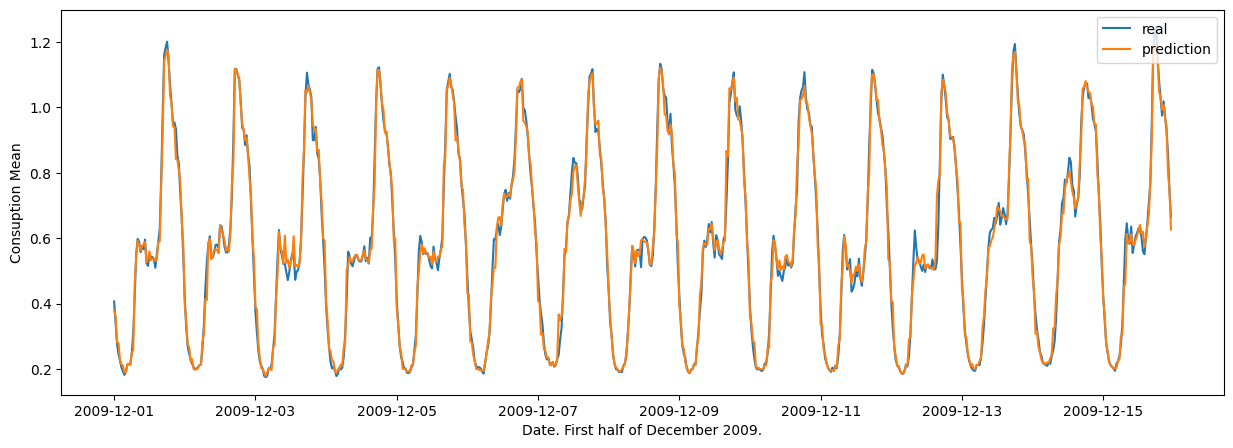

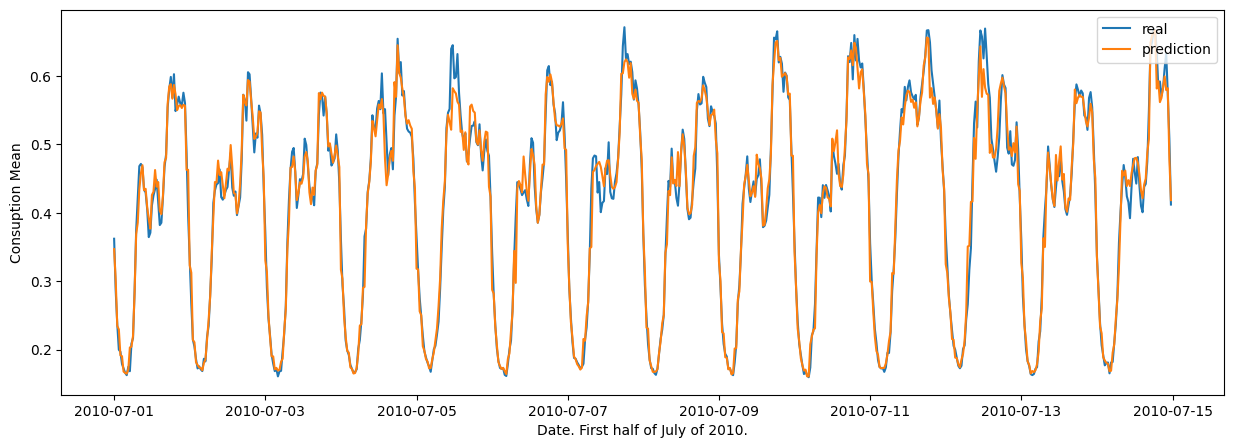

In [408]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x_end_december_2009.index, y_end_december_2009)
plt.plot(x_end_december_2009.index, y_predicted_end_december_2009)
ax.legend(['real', 'prediction'], loc='upper right')
ax.set_xlabel("Date. First half of December 2009.")
ax.set_ylabel("Consuption Mean")

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x_begin_july_2010.index, y_begin_july_2010)
plt.plot(x_begin_july_2010.index, y_predicted_begin_july_2010)
ax.legend(['real', 'prediction'], loc='upper right')
ax.set_xlabel("Date. First half of July of 2010.")
ax.set_ylabel("Consuption Mean")

MAPE ERROR

In [409]:
y_test_predicted = regr_optimal.predict(x_test)
mape_test_data = mean_absolute_percentage_error(y_test, y_test_predicted) * 100
mape_end_december_2009 = mean_absolute_percentage_error(y_predicted_end_december_2009, y_end_december_2009) * 100

print("MAPE Test Data = " + str(round(mape_test_data, 3)) + "%")
print("MAPE End of December 2009 = " + str(round(mape_end_december_2009, 3)) + "%")

MAPE Test Data = 7.609%
MAPE End of December 2009 = 3.752%


Plot of predictions

Text(0, 0.5, 'Consuption Mean')

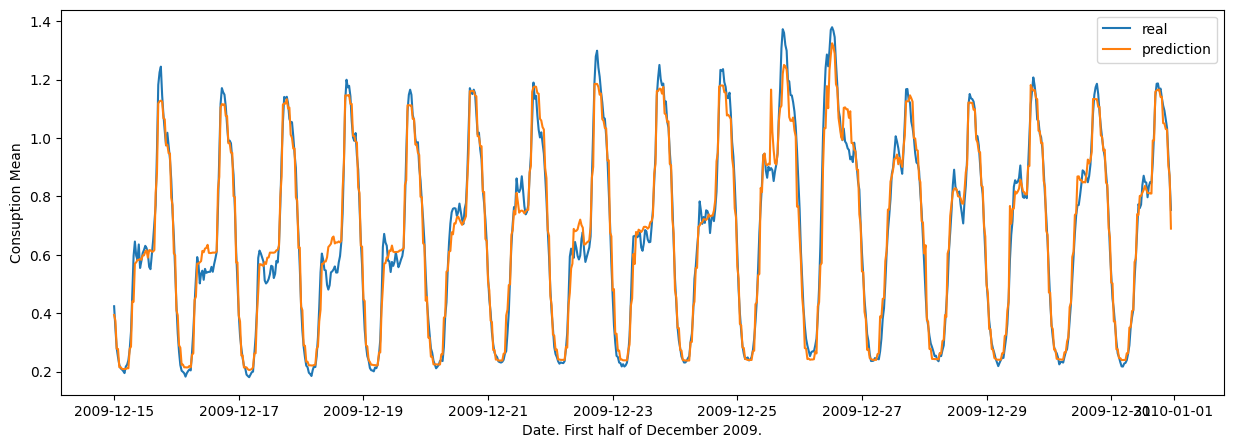

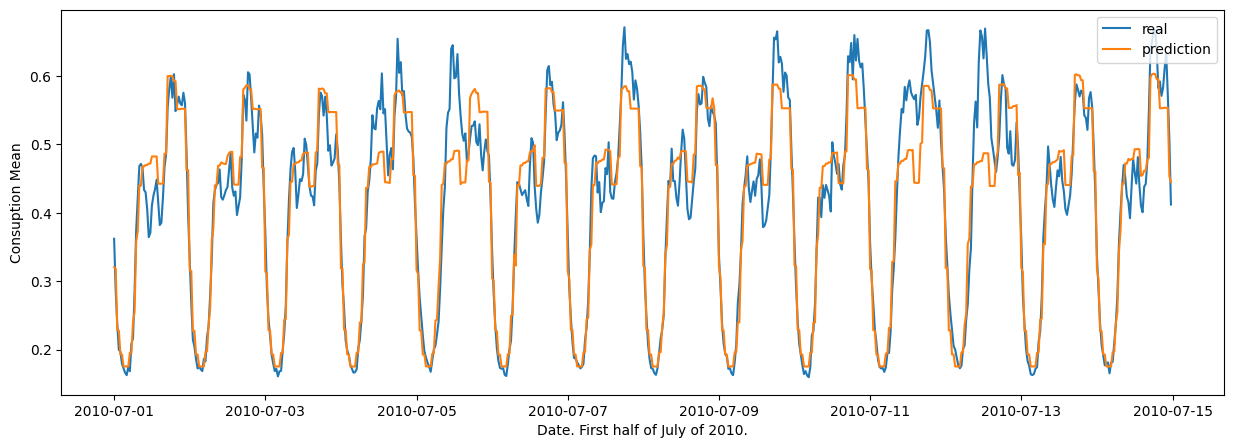

In [410]:
date_to_be_cropped_begin = datetime.datetime(2009, 12, 15, 0, 0)
date_to_be_cropped_end = datetime.datetime(2009, 12, 31, 23, 30)
data_end_december_2009 = df_to_train_and_test[df_to_train_and_test.index >= date_to_be_cropped_begin]
data_end_december_2009 = data_end_december_2009[data_end_december_2009.index < date_to_be_cropped_end]
y_end_december_2009 = data_end_december_2009['mean']
x_end_december_2009 = data_end_december_2009[variables]
y_predicted_end_december_2009 = regr_optimal_hard.predict(x_end_december_2009)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x_end_december_2009.index, y_end_december_2009)
plt.plot(x_end_december_2009.index, y_predicted_end_december_2009)
ax.legend(['real', 'prediction'], loc='upper right')
ax.set_xlabel("Date. First half of December 2009.")
ax.set_ylabel("Consuption Mean")

date_to_be_cropped_begin = datetime.datetime(2010, 7, 1, 0, 0)
date_to_be_cropped_end = datetime.datetime(2010, 7, 15, 0, 0)
data_begin_july_2010 = df_to_train_and_test[df_to_train_and_test.index >= date_to_be_cropped_begin]
data_begin_july_2010 = data_begin_july_2010[data_begin_july_2010.index < date_to_be_cropped_end]
y_begin_july_2010 = data_begin_july_2010['mean']
x_begin_july_2010 = data_begin_july_2010[variables]
y_predicted_begin_july_2010 = regr_optimal_hard.predict(x_begin_july_2010[variables])

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x_begin_july_2010.index, y_begin_july_2010)
plt.plot(x_begin_july_2010.index, y_predicted_begin_july_2010)
ax.legend(['real', 'prediction'], loc='upper right')
ax.set_xlabel("Date. First half of July of 2010.")
ax.set_ylabel("Consuption Mean")

MAPE with hard data

In [411]:
y_hard_test_predicted = regr_optimal_hard.predict(x_test_hard)
mape_test_data = mean_absolute_percentage_error(y_test_hard, y_hard_test_predicted) * 100
mape_end_december_2009 = mean_absolute_percentage_error(y_predicted_end_december_2009, y_end_december_2009) * 100

print("MAPE Test Data = " + str(round(mape_test_data, 3)) + "%")
print("MAPE End of December 2009 = " + str(round(mape_end_december_2009, 3)) + "%")

MAPE Test Data = 8.524%
MAPE End of December 2009 = 6.389%
